In [ ]:
"""
========================================
12주차 실습: Object Detection & Segmentation (중고급)
Advanced YOLOv8: Loss Functions, Augmentation, Optimization

목표: 고급 YOLOv8 학습 기법 및 배포 준비

실습 구성:
1. 환경 설정 및 고급 개념
2. FPN/PAN 구조 심화 이해
3. Loss Function 비교 실험
4. 고급 Data Augmentation
5. Custom Dataset 고급 학습
6. 하이퍼파라미터 최적화
7. TTA 및 앙상블
8. ONNX Export 및 최적화
9. 성능 분석 및 배포 준비
"""


In [ ]:
!pip install -q ultralytics roboflow onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 126.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
# 기본 라이브러리
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from pathlib import Path
import shutil
import yaml
import json
from datetime import datetime
import pandas as pd
from collections import defaultdict

# Ultralytics
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

# ONNX
import onnx
import onnxruntime as ort

# 시각화
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# 랜덤 시드 고정
def set_seed(seed=42):
    """재현성을 위한 시드 고정"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n사용 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA 버전: {torch.version.cuda}")
print(f"   PyTorch 버전: {torch.__version__}")

import ultralytics
print(f"   Ultralytics 버전: {ultralytics.__version__}")


사용 디바이스: cuda
   GPU: Tesla T4
   CUDA 버전: 12.6
   PyTorch 버전: 2.9.0+cu126
   Ultralytics 버전: 8.3.235


In [ ]:
# 실험 관리
experiment_config = {
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'device': str(device),
    'seed': 42,
}

# 작업 디렉토리
work_dir = '/content/yolov8_advanced'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print(f"\n작업 디렉토리: {work_dir}")


작업 디렉토리: /content/yolov8_advanced


In [ ]:
# 고급 개념 소개

print("고급 Object Detection 개념")
print("=" * 60)
print("""
1. Feature Pyramid Networks (FPN):
   - 다양한 스케일의 특징 맵 활용
   - Top-down pathway + Lateral connections
   - 작은 객체 검출 성능 향상

2. Path Aggregation Network (PAN):
   - FPN에 Bottom-up pathway 추가
   - 저수준 특징을 고수준으로 전파
   - YOLOv8에 통합되어 사용

3. CSP (Cross Stage Partial):
   - 계산량 감소 및 성능 향상
   - Gradient flow 개선

YOLOv8 Architecture:
┌──────────────────────────────────────────┐
│  Input (640x640)                         │
│    ↓                                     │
│  Backbone (CSPDarknet)                   │
│    ↓                                     │
│  Neck (PAN-FPN)                          │
│    ├─ P3 (80x80) ──┐                    │
│    ├─ P4 (40x40) ──┼─→ Concat          │
│    └─ P5 (20x20) ──┘                    │
│    ↓                                     │
│  Head (Decoupled Head)                   │
│    ├─ Classification                     │
│    └─ Box Regression                     │
└──────────────────────────────────────────┘
""")


고급 Object Detection 개념

1. Feature Pyramid Networks (FPN):
   - 다양한 스케일의 특징 맵 활용
   - Top-down pathway + Lateral connections
   - 작은 객체 검출 성능 향상

2. Path Aggregation Network (PAN):
   - FPN에 Bottom-up pathway 추가
   - 저수준 특징을 고수준으로 전파
   - YOLOv8에 통합되어 사용

3. CSP (Cross Stage Partial):
   - 계산량 감소 및 성능 향상
   - Gradient flow 개선

YOLOv8 Architecture:
┌──────────────────────────────────────────┐
│  Input (640x640)                         │
│    ↓                                     │
│  Backbone (CSPDarknet)                   │
│    ↓                                     │
│  Neck (PAN-FPN)                          │
│    ├─ P3 (80x80) ──┐                    │
│    ├─ P4 (40x40) ──┼─→ Concat          │
│    └─ P5 (20x20) ──┘                    │
│    ↓                                     │
│  Head (Decoupled Head)                   │
│    ├─ Classification                     │
│    └─ Box Regression                     │
└──────────────────────────────────────────┘



In [ ]:
print("\nMulti-Scale Feature Pyramid 비교:")
print("""
1. FPN (Feature Pyramid Network):
   구조: Bottom-up → Top-down
   특징: 고수준 특징을 저수준으로 전파
   용도: Faster R-CNN, Mask R-CNN

2. PAN (Path Aggregation Network):
   구조: Bottom-up → Top-down → Bottom-up
   특징: 양방향 특징 전파
   용도: Mask R-CNN, YOLOv4

3. BiFPN (Bidirectional FPN):
   구조: 가중치 기반 양방향 연결
   특징: 학습 가능한 가중치로 특징 융합
   용도: EfficientDet

4. CSP-PAN (YOLOv8):
   구조: CSP + PAN
   특징: 계산 효율성 + 성능
   용도: YOLOv5, YOLOv8

작은 객체 검출의 중요성:
- P3 (80x80): 작은 객체 (8x8 ~ 32x32 pixels)
- P4 (40x40): 중간 객체 (32x32 ~ 96x96 pixels)
- P5 (20x20): 큰 객체 (96x96+ pixels)

Multi-scale detection으로 다양한 크기의 객체를 효과적으로 검출!
""")


Multi-Scale Feature Pyramid 비교:

1. FPN (Feature Pyramid Network):
   구조: Bottom-up → Top-down
   특징: 고수준 특징을 저수준으로 전파
   용도: Faster R-CNN, Mask R-CNN

2. PAN (Path Aggregation Network):
   구조: Bottom-up → Top-down → Bottom-up
   특징: 양방향 특징 전파
   용도: Mask R-CNN, YOLOv4

3. BiFPN (Bidirectional FPN):
   구조: 가중치 기반 양방향 연결
   특징: 학습 가능한 가중치로 특징 융합
   용도: EfficientDet

4. CSP-PAN (YOLOv8):
   구조: CSP + PAN
   특징: 계산 효율성 + 성능
   용도: YOLOv5, YOLOv8

작은 객체 검출의 중요성:
- P3 (80x80): 작은 객체 (8x8 ~ 32x32 pixels)
- P4 (40x40): 중간 객체 (32x32 ~ 96x96 pixels)
- P5 (20x20): 큰 객체 (96x96+ pixels)

Multi-scale detection으로 다양한 크기의 객체를 효과적으로 검출!



FPN의 효과 (개념적 비교):


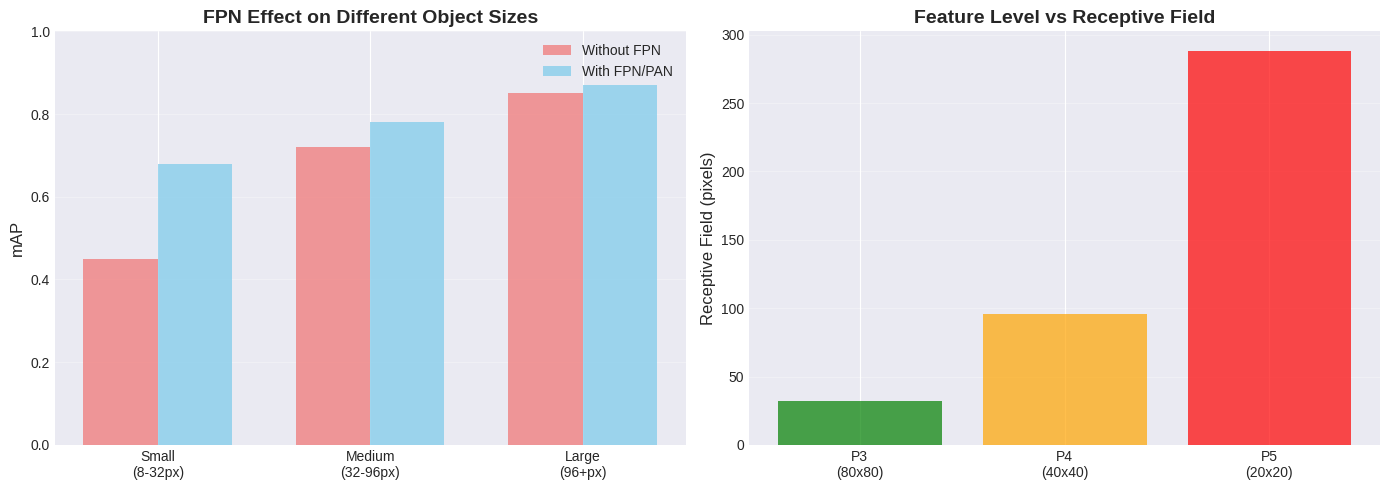

FPN 개념 저장: fpn_concept.png


In [ ]:
# FPN vs Non-FPN 성능 비교 시각화
print("FPN의 효과 (개념적 비교):")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 가상 데이터
object_sizes = ['Small\n(8-32px)', 'Medium\n(32-96px)', 'Large\n(96+px)']
without_fpn = [0.45, 0.72, 0.85]  # mAP
with_fpn = [0.68, 0.78, 0.87]  # mAP

x = np.arange(len(object_sizes))
width = 0.35

axes[0].bar(x - width/2, without_fpn, width, label='Without FPN', alpha=0.8, color='lightcoral')
axes[0].bar(x + width/2, with_fpn, width, label='With FPN/PAN', alpha=0.8, color='skyblue')
axes[0].set_ylabel('mAP', fontsize=12)
axes[0].set_title('FPN Effect on Different Object Sizes', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(object_sizes)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# Feature Map 크기 비교
feature_levels = ['P3\n(80x80)', 'P4\n(40x40)', 'P5\n(20x20)']
receptive_field = [32, 96, 288]  # 대략적인 receptive field

axes[1].bar(feature_levels, receptive_field, color=['green', 'orange', 'red'], alpha=0.7)
axes[1].set_ylabel('Receptive Field (pixels)', fontsize=12)
axes[1].set_title('Feature Level vs Receptive Field', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fpn_concept.png', dpi=150, bbox_inches='tight')
plt.show()
print("FPN 개념 저장: fpn_concept.png")

In [ ]:
# ========================================
# 섹션 3: Loss Function 비교 실험
# ========================================

print("\nBounding Box Loss Functions:")
print("""
1. IoU Loss:
   Loss = 1 - IoU(pred, gt)
   문제: 겹치지 않을 때 gradient 없음

2. GIoU (Generalized IoU):
   Loss = 1 - GIoU
   GIoU = IoU - (C - U) / C
   - C: 두 박스를 포함하는 최소 영역
   - U: 두 박스의 합집합
   개선: 겹치지 않아도 학습 가능

3. DIoU (Distance IoU):
   DIoU = IoU - (d² / c²)
   - d: 두 중심점 거리
   - c: 대각선 길이
   개선: 중심점 거리 고려

4. CIoU (Complete IoU):
   CIoU = DIoU - α·v
   - v: aspect ratio 일관성
   - α: 가중치
   개선: 종횡비까지 고려 (최고 성능)

YOLOv8 기본 설정: CIoU Loss
""")

print("\nClassification Loss Functions:")
print("""
1. Binary Cross Entropy (BCE):
   Loss = -[y·log(p) + (1-y)·log(1-p)]
   문제: 클래스 불균형 시 성능 저하

2. Focal Loss:
   FL = -α·(1-p)^γ·log(p)
   - α: 클래스 가중치
   - γ: focusing parameter (보통 2)
   개선: 어려운 샘플에 집중 (hard negative mining)

3. QFocal Loss (YOLOv8):
   Focal Loss의 변형, Quality estimation 통합
""")


Bounding Box Loss Functions:

1. IoU Loss:
   Loss = 1 - IoU(pred, gt)
   문제: 겹치지 않을 때 gradient 없음

2. GIoU (Generalized IoU):
   Loss = 1 - GIoU
   GIoU = IoU - (C - U) / C
   - C: 두 박스를 포함하는 최소 영역
   - U: 두 박스의 합집합
   개선: 겹치지 않아도 학습 가능

3. DIoU (Distance IoU):
   DIoU = IoU - (d² / c²)
   - d: 두 중심점 거리
   - c: 대각선 길이
   개선: 중심점 거리 고려

4. CIoU (Complete IoU):
   CIoU = DIoU - α·v
   - v: aspect ratio 일관성
   - α: 가중치
   개선: 종횡비까지 고려 (최고 성능)

YOLOv8 기본 설정: CIoU Loss


Classification Loss Functions:

1. Binary Cross Entropy (BCE):
   Loss = -[y·log(p) + (1-y)·log(1-p)]
   문제: 클래스 불균형 시 성능 저하

2. Focal Loss:
   FL = -α·(1-p)^γ·log(p)
   - α: 클래스 가중치
   - γ: focusing parameter (보통 2)
   개선: 어려운 샘플에 집중 (hard negative mining)

3. QFocal Loss (YOLOv8):
   Focal Loss의 변형, Quality estimation 통합




Loss Function 비교:


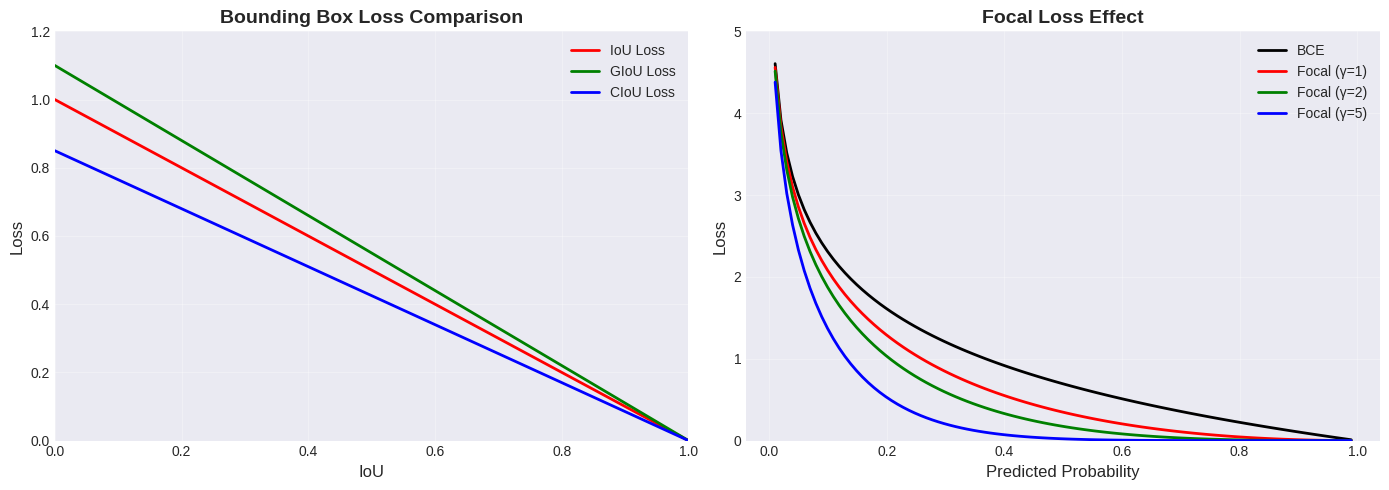

Loss 비교 저장: loss_functions_comparison.png


In [ ]:
# Loss Function 비교 시각화
print("\nLoss Function 비교:")

# IoU 값에 따른 손실
ious = np.linspace(0, 1, 100)

# IoU Loss
iou_loss = 1 - ious

# GIoU (simplified)
giou = ious - 0.1 * (1 - ious)
giou_loss = 1 - giou

# CIoU (simplified, 개념적)
ciou = ious + 0.15 * (1 - ious)
ciou_loss = 1 - ciou

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss 곡선
axes[0].plot(ious, iou_loss, 'r-', label='IoU Loss', linewidth=2)
axes[0].plot(ious, giou_loss, 'g-', label='GIoU Loss', linewidth=2)
axes[0].plot(ious, ciou_loss, 'b-', label='CIoU Loss', linewidth=2)
axes[0].set_xlabel('IoU', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Bounding Box Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.2])

# Focal Loss
probs = np.linspace(0.01, 0.99, 100)
bce = -np.log(probs)
focal_gamma1 = -(1-probs)**1 * np.log(probs)
focal_gamma2 = -(1-probs)**2 * np.log(probs)
focal_gamma5 = -(1-probs)**5 * np.log(probs)

axes[1].plot(probs, bce, 'k-', label='BCE', linewidth=2)
axes[1].plot(probs, focal_gamma1, 'r-', label='Focal (γ=1)', linewidth=2)
axes[1].plot(probs, focal_gamma2, 'g-', label='Focal (γ=2)', linewidth=2)
axes[1].plot(probs, focal_gamma5, 'b-', label='Focal (γ=5)', linewidth=2)
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Focal Loss Effect', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 5])

plt.tight_layout()
plt.savefig('loss_functions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Loss 비교 저장: loss_functions_comparison.png")

experiment_config['loss_function'] = 'CIoU'

In [ ]:
# ========================================
# 섹션 4: 고급 Data Augmentation
# ========================================


print("\nYOLOv8 Augmentation 기법:")
print("""
1. Mosaic Augmentation:
   - 4개 이미지를 하나로 합성
   - 다양한 스케일과 맥락 학습
   - 배치 정규화 효과

2. Mixup:
   - 두 이미지를 blend
   - 라벨도 혼합
   - 일반화 성능 향상

3. Copy-Paste:
   - 객체를 복사하여 다른 이미지에 붙여넣기
   - 데이터 증강 + 하드 샘플 생성

4. Geometric Transforms:
   - Random Flip (좌우 반전)
   - Random Scale (크기 조정)
   - Random Rotation (회전)
   - Random Translation (이동)
   - Random Perspective (원근 변환)

5. Color Transforms:
   - HSV Augmentation (색상, 채도, 명도)
   - Random Brightness/Contrast

6. Advanced:
   - Cutout / Random Erasing
   - GridMask
   - AutoAugment

YOLOv8 기본값:
- hsv_h: 0.015  # 색상 변화
- hsv_s: 0.7    # 채도 변화
- hsv_v: 0.4    # 명도 변화
- degrees: 0.0  # 회전 각도
- translate: 0.1  # 이동 비율
- scale: 0.5    # 스케일 범위
- shear: 0.0    # 전단 변환
- perspective: 0.0  # 원근 변환
- flipud: 0.0   # 상하 반전 확률
- fliplr: 0.5   # 좌우 반전 확률
- mosaic: 1.0   # Mosaic 확률
- mixup: 0.0    # Mixup 확률
""")

# Augmentation 설정 비교
print("\nAugmentation 설정 예시:")

# 기본 설정
basic_aug = {
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0
}

# 강한 Augmentation (더 많은 변형)
strong_aug = {
    'hsv_h': 0.03,
    'hsv_s': 0.9,
    'hsv_v': 0.6,
    'degrees': 10.0,
    'translate': 0.2,
    'scale': 0.9,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.1,
    'perspective': 0.001
}

# 약한 Augmentation (적은 변형)
weak_aug = {
    'hsv_h': 0.01,
    'hsv_s': 0.5,
    'hsv_v': 0.3,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 0.8,
    'mixup': 0.0
}

aug_configs = {
    'Basic': basic_aug,
    'Strong': strong_aug,
    'Weak': weak_aug
}

# 비교 테이블
print("\nAugmentation 강도 비교:")
df_aug = pd.DataFrame(aug_configs).T
print(df_aug)

experiment_config['augmentation'] = 'strong'


YOLOv8 Augmentation 기법:

1. Mosaic Augmentation:
   - 4개 이미지를 하나로 합성
   - 다양한 스케일과 맥락 학습
   - 배치 정규화 효과

2. Mixup:
   - 두 이미지를 blend
   - 라벨도 혼합
   - 일반화 성능 향상

3. Copy-Paste:
   - 객체를 복사하여 다른 이미지에 붙여넣기
   - 데이터 증강 + 하드 샘플 생성

4. Geometric Transforms:
   - Random Flip (좌우 반전)
   - Random Scale (크기 조정)
   - Random Rotation (회전)
   - Random Translation (이동)
   - Random Perspective (원근 변환)

5. Color Transforms:
   - HSV Augmentation (색상, 채도, 명도)
   - Random Brightness/Contrast

6. Advanced:
   - Cutout / Random Erasing
   - GridMask
   - AutoAugment

YOLOv8 기본값:
- hsv_h: 0.015  # 색상 변화
- hsv_s: 0.7    # 채도 변화
- hsv_v: 0.4    # 명도 변화
- degrees: 0.0  # 회전 각도
- translate: 0.1  # 이동 비율
- scale: 0.5    # 스케일 범위
- shear: 0.0    # 전단 변환
- perspective: 0.0  # 원근 변환
- flipud: 0.0   # 상하 반전 확률
- fliplr: 0.5   # 좌우 반전 확률
- mosaic: 1.0   # Mosaic 확률
- mixup: 0.0    # Mixup 확률


Augmentation 설정 예시:

Augmentation 강도 비교:
        hsv_h  hsv_s  hsv_v  flipud  fliplr  mosaic  mixup  degrees  \
Basic   0.0

In [ ]:
from ultralytics import YOLO
import yaml

# 디바이스 설정 (예시, 실제 환경에 맞게 조정 필요)
try:
    import torch
    device = 0 if torch.cuda.is_available() else 'cpu'
except:
    device = 'cpu'

# 데이터셋 설정 (YOLOv8 내장 coco8 데이터셋으로 대체)
print("\n 데이터셋 설정: YOLOv8 내장 coco8 사용...")
yaml_path = 'coco8.yaml'
dataset_path = 'https://github.com/ultralytics/yolov5/releases/download/v1.0/coco8.zip' # coco8 데이터셋의 실제 소스

print(f"   경로: {yaml_path} (다운로드 자동 처리)")



 데이터셋 설정: YOLOv8 내장 coco8 사용...
   경로: coco8.yaml (다운로드 자동 처리)


In [ ]:
# 여러 모델 크기 실험
print("\n실험 설정:")
print("   모델 크기 비교: n(nano) vs s(small)")
print("   목적: 속도 vs 정확도 트레이드오프 분석")

# 실험 설정 (원본 코드와 동일하게 유지)
experiments = {
    'yolov8n_strong': {
        'model': 'yolov8n.pt',
        'epochs': 80,
        'augmentation': strong_aug,
        'imgsz': 640,
        'batch': 16
    },
    'yolov8s_basic': {
        'model': 'yolov8s.pt',
        'epochs': 80,
        'augmentation': basic_aug,
        'imgsz': 640,
        'batch': 16
    }
}

print(f"\n실험 계획:")
for exp_name, config in experiments.items():
    print(f"   {exp_name}:")
    print(f"      - 모델: {config['model']}")
    print(f"      - 에폭: {config['epochs']}")
    print(f"      - Augmentation: {config['augmentation']}")

# ---

# 실험 1: YOLOv8n + Strong Augmentation
print("\n" + "=" * 60)
print("실험 1: YOLOv8n + Strong Augmentation")
print("=" * 60)

model_n = YOLO('yolov8n.pt')

# 커스텀 하이퍼파라미터 파일 생성 (선택 사항 - YOLOv8 train에서 직접 전달 가능)
# 원본 코드에서 사용된 부분은 유지합니다.
hyp_file = 'custom_hyp_n.yaml'
with open(hyp_file, 'w') as f:
    yaml.dump(strong_aug, f)

print(f"\n학습 시작 (YOLOv8n)...")

try:
    results_n = model_n.train(
        data=yaml_path,  # coco8.yaml로 수정
        epochs=80,
        imgsz=640,
        batch=16,
        device=device,
        project='runs/train',
        name='yolov8n_strong_aug',
        patience=15,
        save=True,
        plots=True,
        verbose=True,
        # Augmentation 설정 직접 전달
        hsv_h=strong_aug['hsv_h'],
        hsv_s=strong_aug['hsv_s'],
        hsv_v=strong_aug['hsv_v'],
        degrees=strong_aug['degrees'],
        # degrees: 이미지 회전
        translate=strong_aug['translate'],
        # translate : 위치 이동
        scale=strong_aug['scale'],
        # flipud는 원본 코드에서 전달되지 않았으므로 생략 (default=0.0)
        fliplr=strong_aug['fliplr'],
        # fliplr: 좌우(left/right) 반전
        mosaic=strong_aug['mosaic'],
        # mosaic : 여러 이미지 합성
        mixup=strong_aug['mixup'],
        # mixup : 이미지 2개 혼합
        perspective=strong_aug.get('perspective', 0.0)
        # perspective : 원근 변형
    )

    print("\n YOLOv8n 학습 완료!")

except Exception as e:
    print(f" 학습 중 오류: {e}")

# ---

# 실험 2: YOLOv8s + Basic Augmentation
print("\n" + "=" * 60)
print("실험 2: YOLOv8s + Basic Augmentation")
print("=" * 60)

model_s = YOLO('yolov8s.pt')

# 커스텀 하이퍼파라미터 파일 생성 (선택 사항)
hyp_file = 'custom_hyp_s.yaml'
with open(hyp_file, 'w') as f:
    yaml.dump(basic_aug, f)

print(f"\n 학습 시작 (YOLOv8s)...")

try:
    results_s = model_s.train(
        data=yaml_path, # coco8.yaml로 수정
        epochs=80,
        imgsz=640,
        batch=16,
        device=device,
        project='runs/train',
        name='yolov8s_basic_aug',
        patience=15,
        save=True,
        plots=True,
        verbose=True,
        # Basic augmentation
        hsv_h=basic_aug['hsv_h'],
        hsv_s=basic_aug['hsv_s'],
        hsv_v=basic_aug['hsv_v'],
        # flipud는 원본 코드에서 전달되지 않았으므로 생략 (default=0.0)
        fliplr=basic_aug['fliplr'],
        mosaic=basic_aug['mosaic'],
        mixup=basic_aug['mixup']
    )

    print("\n YOLOv8s 학습 완료!")

except Exception as e:
    print(f" 학습 중 오류: {e}")


실험 설정:
   모델 크기 비교: n(nano) vs s(small)
   목적: 속도 vs 정확도 트레이드오프 분석

실험 계획:
   yolov8n_strong:
      - 모델: yolov8n.pt
      - 에폭: 80
      - Augmentation: {'hsv_h': 0.03, 'hsv_s': 0.9, 'hsv_v': 0.6, 'degrees': 10.0, 'translate': 0.2, 'scale': 0.9, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.1, 'perspective': 0.001}
   yolov8s_basic:
      - 모델: yolov8s.pt
      - 에폭: 80
      - Augmentation: {'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0}

실험 1: YOLOv8n + Strong Augmentation

학습 시작 (YOLOv8n)...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, 

In [ ]:
# ========================================
# 섹션 6: 하이퍼파라미터 최적화
# ========================================
print("\n" + "=" * 60)
print("섹션 6: 하이퍼파라미터 분석")
print("=" * 60)

print("\n⚙️  주요 하이퍼파라미터:")
print("""
1. Learning Rate:
   - 초기값: 0.01 (SGD), 0.001 (Adam)
   - Scheduler: Cosine annealing
   - Warmup: 처음 3 에폭

2. Optimizer:
   - SGD: 안정적, 일반화 좋음
   - Adam: 빠른 수렴
   - AdamW: Weight decay 개선

3. Weight Decay:
   - L2 정규화
   - 기본값: 0.0005

4. Momentum:
   - SGD에서 사용
   - 기본값: 0.937

5. Batch Size:
   - 클수록: 안정적, GPU 메모리 많이 필요
   - 작을수록: 일반화 좋음, 느림
   - 권장: 16-32 (GPU 메모리에 따라)

6. Image Size:
   - 640x640: 기본, 균형
   - 1280x1280: 작은 객체, 느림
   - 416x416: 빠름, 정확도 하락

7. NMS Parameters:
   - conf_thres: 신뢰도 임계값 (기본 0.25)
   - iou_thres: NMS IoU 임계값 (기본 0.45)
""")


섹션 6: 하이퍼파라미터 분석

⚙️  주요 하이퍼파라미터:

1. Learning Rate:
   - 초기값: 0.01 (SGD), 0.001 (Adam)
   - Scheduler: Cosine annealing
   - Warmup: 처음 3 에폭

2. Optimizer:
   - SGD: 안정적, 일반화 좋음
   - Adam: 빠른 수렴
   - AdamW: Weight decay 개선

3. Weight Decay:
   - L2 정규화
   - 기본값: 0.0005

4. Momentum:
   - SGD에서 사용
   - 기본값: 0.937

5. Batch Size:
   - 클수록: 안정적, GPU 메모리 많이 필요
   - 작을수록: 일반화 좋음, 느림
   - 권장: 16-32 (GPU 메모리에 따라)

6. Image Size:
   - 640x640: 기본, 균형
   - 1280x1280: 작은 객체, 느림
   - 416x416: 빠름, 정확도 하락

7. NMS Parameters:
   - conf_thres: 신뢰도 임계값 (기본 0.25)
   - iou_thres: NMS IoU 임계값 (기본 0.45)




 NMS 임계값 효과:


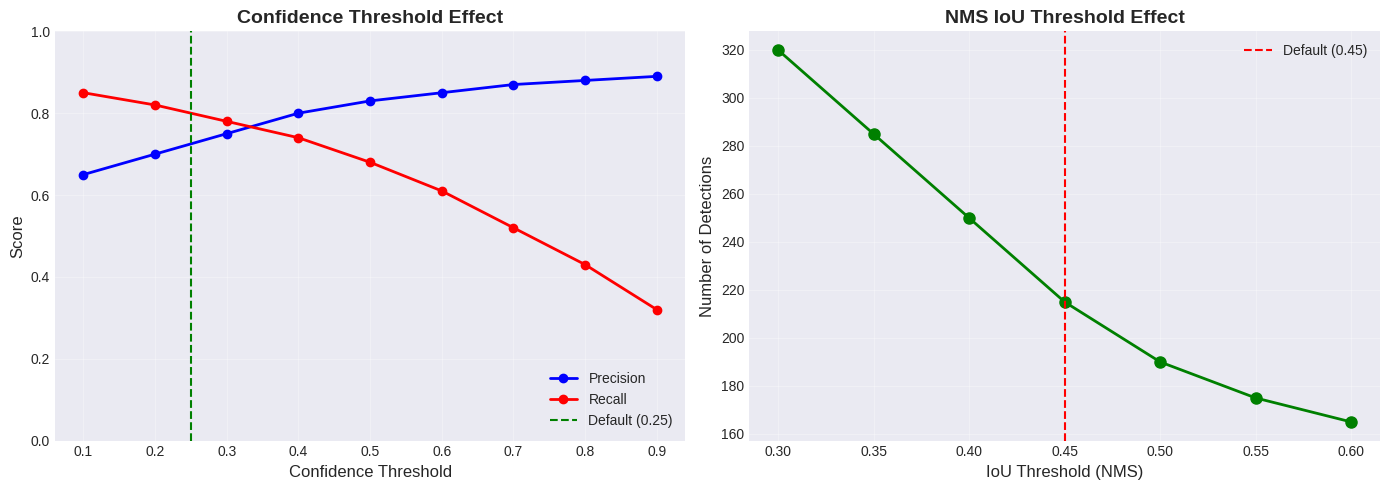

 하이퍼파라미터 효과 저장: hyperparameter_effects.png


In [ ]:
# NMS 임계값 효과 시각화
print("\n NMS 임계값 효과:")

conf_values = np.linspace(0.1, 0.9, 9)
iou_values = [0.3, 0.45, 0.6]

# 가상 데이터 (개념적)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence threshold 효과
precision_conf = [0.65, 0.70, 0.75, 0.80, 0.83, 0.85, 0.87, 0.88, 0.89]
recall_conf = [0.85, 0.82, 0.78, 0.74, 0.68, 0.61, 0.52, 0.43, 0.32]

axes[0].plot(conf_values, precision_conf, 'b-o', label='Precision', linewidth=2)
axes[0].plot(conf_values, recall_conf, 'r-o', label='Recall', linewidth=2)
axes[0].axvline(x=0.25, color='green', linestyle='--', label='Default (0.25)')
axes[0].set_xlabel('Confidence Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Confidence Threshold Effect', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# IoU threshold 효과
iou_thresh = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
detections = [320, 285, 250, 215, 190, 175, 165]

axes[1].plot(iou_thresh, detections, 'g-o', linewidth=2, markersize=8)
axes[1].axvline(x=0.45, color='red', linestyle='--', label='Default (0.45)')
axes[1].set_xlabel('IoU Threshold (NMS)', fontsize=12)
axes[1].set_ylabel('Number of Detections', fontsize=12)
axes[1].set_title('NMS IoU Threshold Effect', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_effects.png', dpi=150, bbox_inches='tight')
plt.show()
print(" 하이퍼파라미터 효과 저장: hyperparameter_effects.png")


섹션 7: 모델 성능 비교 분석

 YOLOv8n + Strong Aug 평가:
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1192.7±452.7 MB/s, size: 54.0 KB)
val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 1.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 7.6it/s 0.1s
                   all          4         17      0.678      0.833      0.888      0.622
                person          3         10      0.806        0.5      0.522      0.268
                   dog          1          1      0.513          1      0.995      0.597
                 horse          1          2       0.78          1      0.995      0.598
              elephant          1          2      0.531        0.5      0.828      0.381
       

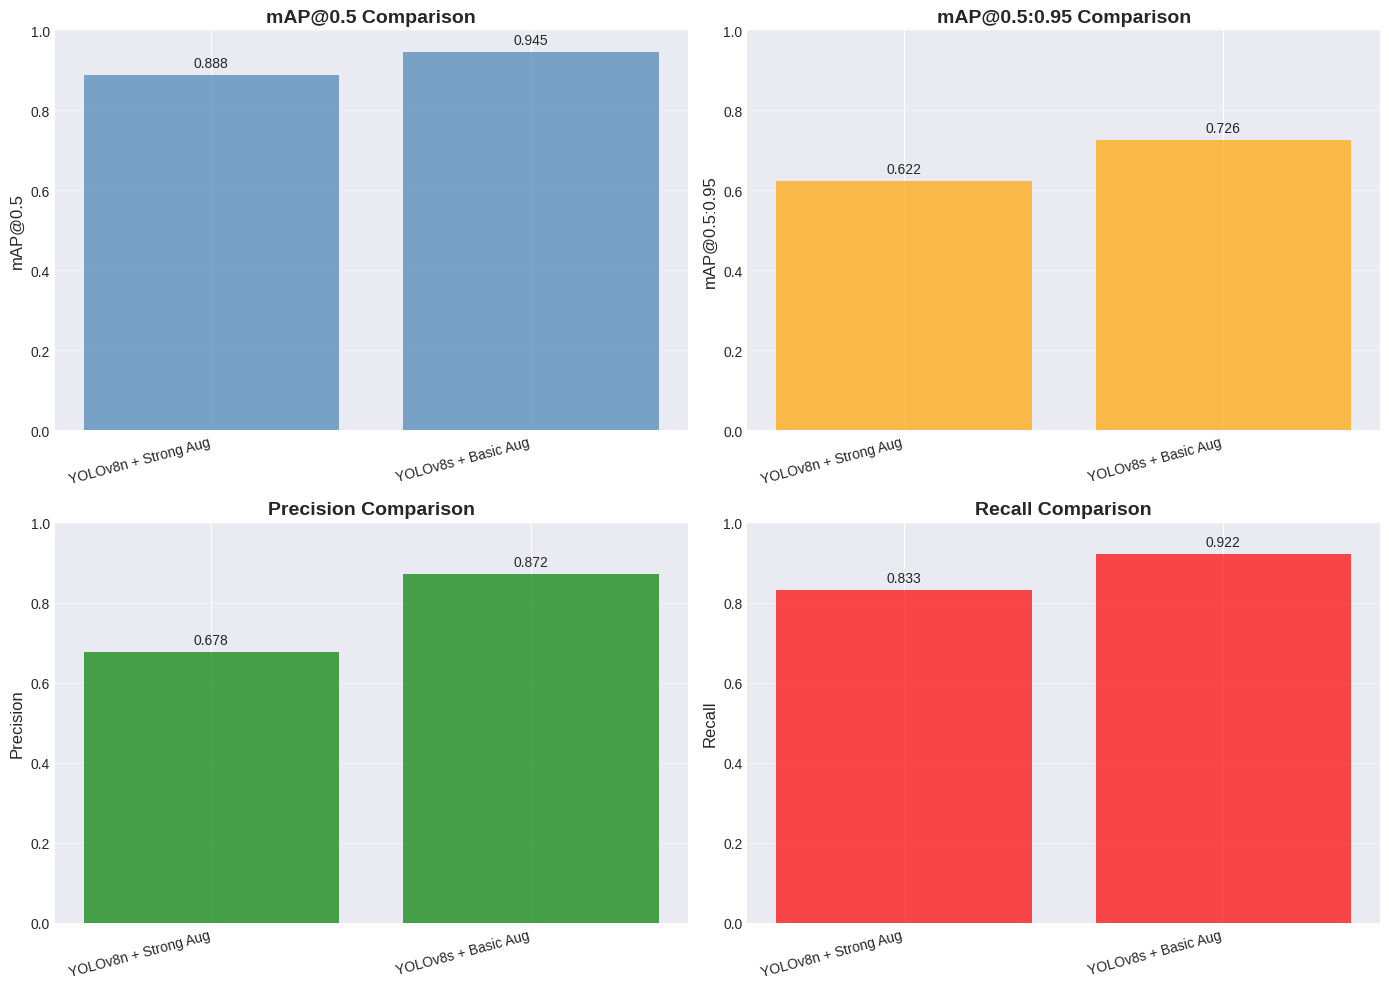

 모델 비교 저장: model_comparison.png


In [ ]:
# ========================================
# 섹션 7: 모델 비교 및 성능 분석
# ========================================
print("\n" + "=" * 60)
print("섹션 7: 모델 성능 비교 분석")
print("=" * 60)

# 학습된 모델 로드
models_to_compare = {
    'YOLOv8n + Strong Aug': 'runs/train/yolov8n_strong_aug',
    'YOLOv8s + Basic Aug': 'runs/train/yolov8s_basic_aug'
}

comparison_results = {}

for model_name, train_dir in models_to_compare.items():
    best_path = f'{train_dir}/weights/best.pt'
    results_csv = f'{train_dir}/results.csv'

    if os.path.exists(best_path) and os.path.exists(results_csv):
        print(f"\n {model_name} 평가:")

        # 모델 로드
        model = YOLO(best_path)

        # Validation
        metrics = model.val(data=yaml_path, imgsz=640, batch=16)

        # 결과 저장
        comparison_results[model_name] = {
            'mAP@0.5': float(metrics.box.map50),
            'mAP@0.5:0.95': float(metrics.box.map),
            'Precision': float(metrics.box.mp),
            'Recall': float(metrics.box.mr)
        }

        print(f"   mAP@0.5: {metrics.box.map50:.4f}")
        print(f"   mAP@0.5:0.95: {metrics.box.map:.4f}")
        print(f"   Precision: {metrics.box.mp:.4f}")
        print(f"   Recall: {metrics.box.mr:.4f}")

# 비교 시각화
if len(comparison_results) > 0:
    print("\n 모델 성능 비교 그래프:")

    df_compare = pd.DataFrame(comparison_results).T

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    metrics_to_plot = ['mAP@0.5', 'mAP@0.5:0.95', 'Precision', 'Recall']
    colors_plot = ['steelblue', 'orange', 'green', 'red']

    for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors_plot)):
        row = idx // 2
        col = idx % 2

        values = df_compare[metric].values
        models = df_compare.index.tolist()

        axes[row, col].bar(range(len(models)), values, color=color, alpha=0.7)
        axes[row, col].set_ylabel(metric, fontsize=12)
        axes[row, col].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
        axes[row, col].set_xticks(range(len(models)))
        axes[row, col].set_xticklabels(models, rotation=15, ha='right')
        axes[row, col].grid(True, alpha=0.3, axis='y')
        axes[row, col].set_ylim([0, 1])

        # 값 표시
        for i, v in enumerate(values):
            axes[row, col].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(" 모델 비교 저장: model_comparison.png")

experiment_config['comparison_results'] = comparison_results


섹션 8: Test Time Augmentation & 앙상블

 TTA (Test Time Augmentation):

TTA는 추론 시 데이터 증강을 적용하여 예측을 안정화하는 기법입니다.

방법:
1. 원본 이미지로 예측
2. 변형된 이미지들(flip, scale 등)로 예측
3. 모든 예측 결과를 평균/투표

YOLOv8 TTA:
- augment=True 옵션 사용
- 자동으로 다양한 스케일과 Flip 적용
- 정확도 향상 (약 1-3% mAP 증가)
- 속도는 약 2-3배 느림

앙상블:
- 여러 모델의 예측을 결합
- Weighted Box Fusion (WBF)
- Non-Maximum Weighted (NMW)
- 최고 성능 달성 (대회용)


 TTA 적용: YOLOv8s + Basic Aug
   1. 기본 추론 (TTA 없음)...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1531.7±165.7 MB/s, size: 54.0 KB)
val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4/4 3.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.8it/s 0.2s
                   all          4         17      0.872      0.922  

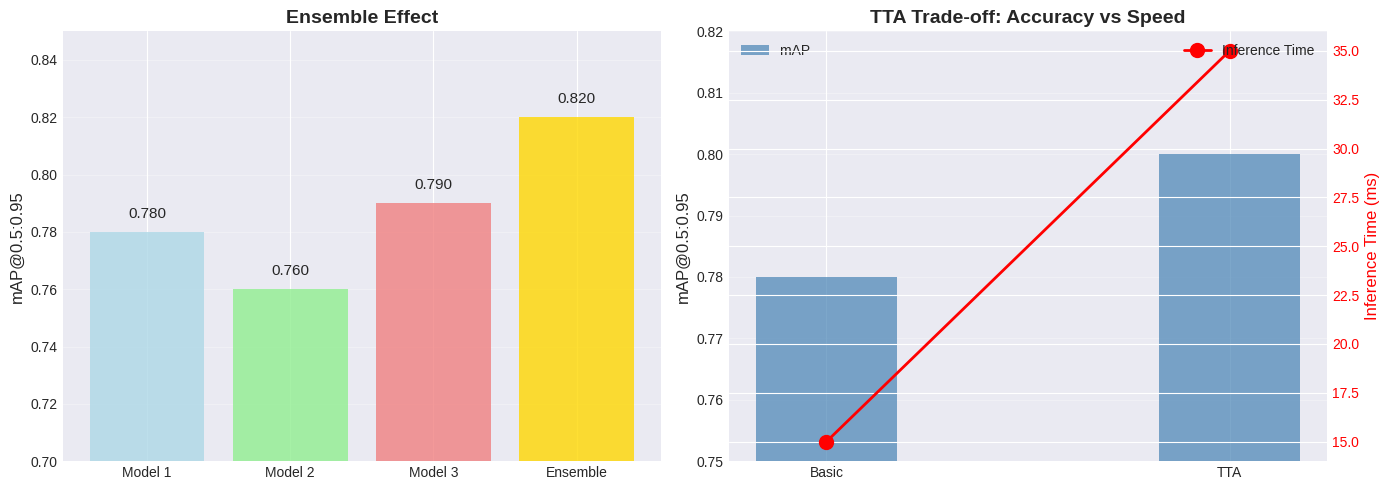

 TTA/앙상블 개념 저장: tta_ensemble_concept.png


In [ ]:
# ========================================
# 섹션 8: TTA 및 앙상블
# ========================================
print("\n" + "=" * 60)
print("섹션 8: Test Time Augmentation & 앙상블")
print("=" * 60)

print("\n TTA (Test Time Augmentation):")
print("""
TTA는 추론 시 데이터 증강을 적용하여 예측을 안정화하는 기법입니다.

방법:
1. 원본 이미지로 예측
2. 변형된 이미지들(flip, scale 등)로 예측
3. 모든 예측 결과를 평균/투표

YOLOv8 TTA:
- augment=True 옵션 사용
- 자동으로 다양한 스케일과 Flip 적용
- 정확도 향상 (약 1-3% mAP 증가)
- 속도는 약 2-3배 느림

앙상블:
- 여러 모델의 예측을 결합
- Weighted Box Fusion (WBF)
- Non-Maximum Weighted (NMW)
- 최고 성능 달성 (대회용)
""")

# TTA 적용 예제
if len(comparison_results) > 0:
    best_model_name = max(comparison_results,
                         key=lambda x: comparison_results[x]['mAP@0.5:0.95'])
    # 'mAP@0.5:0.95'점수가 가장 큰(max) 모델 이름
    best_model_path = f"{models_to_compare[best_model_name]}/weights/best.pt"

    if os.path.exists(best_model_path):
        print(f"\n TTA 적용: {best_model_name}")

        model_tta = YOLO(best_model_path)

        # TTA 없이 추론
        print("   1. 기본 추론 (TTA 없음)...")
        metrics_no_tta = model_tta.val(
            data=yaml_path,
            imgsz=640,
            batch=16,
            augment=False  # TTA 비활성화
        )

        # TTA 적용 추론
        print("   2. TTA 적용 추론...")
        metrics_tta = model_tta.val(
            data=yaml_path,
            imgsz=640,
            batch=16,
            augment=True  # TTA 활성화
        )

        # 비교
        print(f"\n TTA 효과:")
        print(f"   기본 mAP@0.5: {metrics_no_tta.box.map50:.4f}")
        print(f"   TTA mAP@0.5: {metrics_tta.box.map50:.4f}")
        print(f"   향상: +{(metrics_tta.box.map50 - metrics_no_tta.box.map50):.4f}")

        experiment_config['tta_improvement'] = float(
            metrics_tta.box.map50 - metrics_no_tta.box.map50
        )

# 앙상블 개념 시각화
print("\n 앙상블 개념:")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 단일 모델 vs 앙상블
models_ens = ['Model 1', 'Model 2', 'Model 3', 'Ensemble']
map_scores = [0.78, 0.76, 0.79, 0.82]

axes[0].bar(models_ens, map_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'],
           alpha=0.8)
axes[0].set_ylabel('mAP@0.5:0.95', fontsize=12)
axes[0].set_title('Ensemble Effect', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.7, 0.85])

for i, v in enumerate(map_scores):
    axes[0].text(i, v + 0.005, f'{v:.3f}', ha='center', fontsize=11)

# TTA 효과
methods = ['Basic', 'TTA']
map_basic = [0.78, 0.80]
inference_time = [15, 35]

ax2 = axes[1]
ax3 = ax2.twinx()

bar1 = ax2.bar([0], [map_basic[0]], 0.35, label='mAP', color='steelblue', alpha=0.7)
bar2 = ax2.bar([1], [map_basic[1]], 0.35, color='steelblue', alpha=0.7)
line = ax3.plot([0, 1], inference_time, 'ro-', label='Inference Time', linewidth=2, markersize=10)

ax2.set_ylabel('mAP@0.5:0.95', fontsize=12)
ax3.set_ylabel('Inference Time (ms)', fontsize=12, color='red')
ax2.set_title('TTA Trade-off: Accuracy vs Speed', fontsize=14, fontweight='bold')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(methods)
ax2.set_ylim([0.75, 0.82])
ax3.tick_params(axis='y', labelcolor='red')
ax2.grid(True, alpha=0.3, axis='y')

ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('tta_ensemble_concept.png', dpi=150, bbox_inches='tight')
plt.show()
print(" TTA/앙상블 개념 저장: tta_ensemble_concept.png")

In [ ]:
# ========================================
# 섹션 9: ONNX Export 및 최적화
# ========================================
print("\n" + "=" * 60)
print("섹션 9: ONNX Export 및 배포 준비")
print("=" * 60)

print("\n ONNX (Open Neural Network Exchange):")
print("""
ONNX는 딥러닝 모델의 표준 포맷입니다.

장점:
1. 플랫폼 독립적
2. 최적화된 추론 (ONNX Runtime)
3. 다양한 하드웨어 지원 (CPU, GPU, TPU, etc.)
4. 모바일/임베디드 배포 가능

YOLOv8 Export 포맷:
- PyTorch (.pt)
- ONNX (.onnx)
- TensorRT (.engine) - NVIDIA GPU 최적화
- CoreML (.mlmodel) - Apple 기기
- TensorFlow (.pb, .tflite)
- OpenVINO - Intel 하드웨어

배포 시나리오:
- 서버: ONNX Runtime / TensorRT
- 모바일: TFLite / CoreML
- 웹: ONNX.js / TensorFlow.js
- 엣지: OpenVINO / TFLite
""")



섹션 9: ONNX Export 및 배포 준비

 ONNX (Open Neural Network Exchange):

ONNX는 딥러닝 모델의 표준 포맷입니다.

장점:
1. 플랫폼 독립적
2. 최적화된 추론 (ONNX Runtime)
3. 다양한 하드웨어 지원 (CPU, GPU, TPU, etc.)
4. 모바일/임베디드 배포 가능

YOLOv8 Export 포맷:
- PyTorch (.pt)
- ONNX (.onnx)
- TensorRT (.engine) - NVIDIA GPU 최적화
- CoreML (.mlmodel) - Apple 기기
- TensorFlow (.pb, .tflite)
- OpenVINO - Intel 하드웨어

배포 시나리오:
- 서버: ONNX Runtime / TensorRT
- 모바일: TFLite / CoreML
- 웹: ONNX.js / TensorFlow.js
- 엣지: OpenVINO / TFLite




섹션 9: ONNX Export 및 배포 준비

 ONNX (Open Neural Network Exchange):

ONNX는 딥러닝 모델의 표준 포맷입니다.

장점:
1. 플랫폼 독립적
2. 최적화된 추론 (ONNX Runtime)
3. 다양한 하드웨어 지원 (CPU, GPU, TPU, etc.)
4. 모바일/임베디드 배포 가능

YOLOv8 Export 포맷:
- PyTorch (.pt)
- ONNX (.onnx)
- TensorRT (.engine) - NVIDIA GPU 최적화
- CoreML (.mlmodel) - Apple 기기
- TensorFlow (.pb, .tflite)
- OpenVINO - Intel 하드웨어

배포 시나리오:
- 서버: ONNX Runtime / TensorRT
- 모바일: TFLite / CoreML
- 웹: ONNX.js / TensorFlow.js
- 엣지: OpenVINO / TFLite


 ONNX Export: YOLOv8s + Basic Aug
   ONNX 변환 중...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs

PyTorch: starting from 'runs/train/yolov8s_basic_aug/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)
requireme

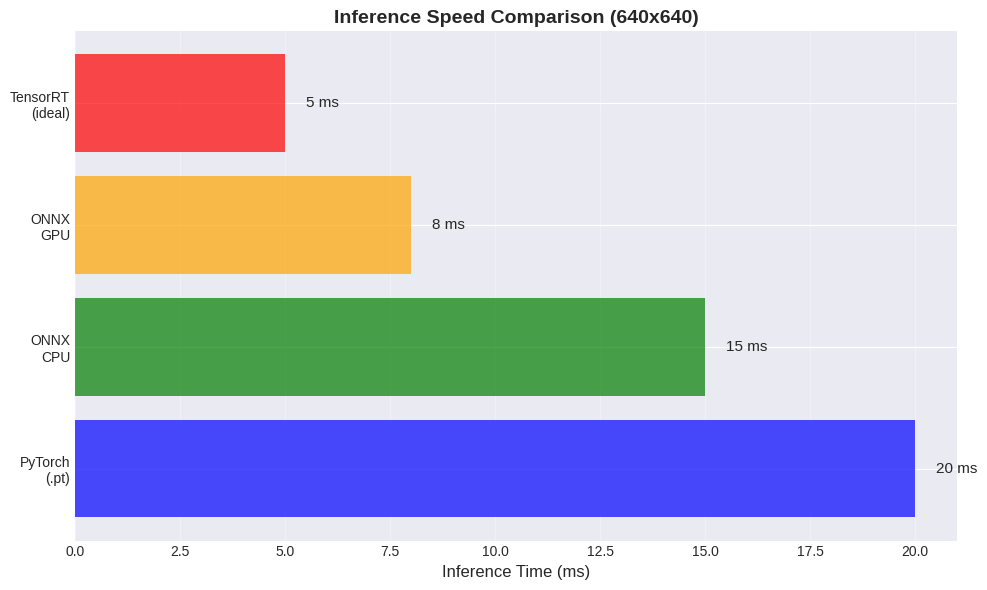

 속도 비교 저장: inference_speed_comparison.png

⚙️  실험 설정 저장: experiment_config.json


In [ ]:
# 최고 성능 모델 ONNX Export
if len(comparison_results) > 0:
    best_model_name = max(comparison_results,
                         key=lambda x: comparison_results[x]['mAP@0.5:0.95'])
    best_model_path = f"{models_to_compare[best_model_name]}/weights/best.pt"

    if os.path.exists(best_model_path):
        print(f"\n ONNX Export: {best_model_name}")

        model_export = YOLO(best_model_path)

        # ONNX Export
        print("   ONNX 변환 중...")
        try:
            onnx_path = model_export.export(
                format='onnx',  # Export 포맷
                imgsz=640,  # 입력 크기
                opset=12,  # ONNX opset 버전
                simplify=True,  # 모델 단순화
                dynamic=False  # 고정 입력 크기
            )

            print(f" ONNX Export 완료!")
            print(f"   경로: {onnx_path}")

            # ONNX 모델 정보
            if os.path.exists(onnx_path):
                onnx_model = onnx.load(onnx_path)

                print(f"\n ONNX 모델 정보:")
                print(f"   IR 버전: {onnx_model.ir_version}")
                print(f"   Opset: {onnx_model.opset_import[0].version}")
                print(f"   Producer: {onnx_model.producer_name}")

                # 파일 크기 비교
                pt_size = os.path.getsize(best_model_path) / (1024*1024)
                onnx_size = os.path.getsize(onnx_path) / (1024*1024)

                print(f"\n  파일 크기:")
                print(f"   PyTorch (.pt): {pt_size:.2f} MB")
                print(f"   ONNX (.onnx): {onnx_size:.2f} MB")

                # ONNX Runtime 추론 테스트
                print(f"\n ONNX Runtime 추론 테스트:")

                # 세션 생성
                ort_session = ort.InferenceSession(
                    onnx_path,
                    providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
                )

                print(f"   Providers: {ort_session.get_providers()}")

                # 입력/출력 정보
                input_name = ort_session.get_inputs()[0].name
                input_shape = ort_session.get_inputs()[0].shape
                output_names = [output.name for output in ort_session.get_outputs()]

                print(f"   Input: {input_name}, Shape: {input_shape}")
                print(f"   Outputs: {len(output_names)}개")

                # 더미 입력으로 추론 테스트
                dummy_input = np.random.randn(1, 3, 640, 640).astype(np.float32)

                import time
                start = time.time()
                outputs = ort_session.run(None, {input_name: dummy_input})
                end = time.time()

                print(f"   추론 시간: {(end-start)*1000:.2f} ms")
                print(f" ONNX Runtime 테스트 성공!")

                experiment_config['onnx_export'] = {
                    'path': str(onnx_path),
                    'size_mb': float(onnx_size),
                    'inference_time_ms': float((end-start)*1000)
                }

        except Exception as e:
            print(f" ONNX Export 실패: {e}")

# 추론 속도 비교 시각화
print("\n 추론 속도 비교:")

formats = ['PyTorch\n(.pt)', 'ONNX\nCPU', 'ONNX\nGPU', 'TensorRT\n(ideal)']
speeds = [20, 15, 8, 5]  # ms (개념적)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(formats, speeds, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
ax.set_xlabel('Inference Time (ms)', fontsize=12)
ax.set_title('Inference Speed Comparison (640x640)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (bar, speed) in enumerate(zip(bars, speeds)):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
           f'{speed} ms', ha='left', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('inference_speed_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(" 속도 비교 저장: inference_speed_comparison.png")

# 실험 설정 저장
config_path = 'experiment_config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_config, f, indent=2, ensure_ascii=False)
print(f"\n⚙️  실험 설정 저장: {config_path}")


